Using FIPS code '09' for input 'CT'


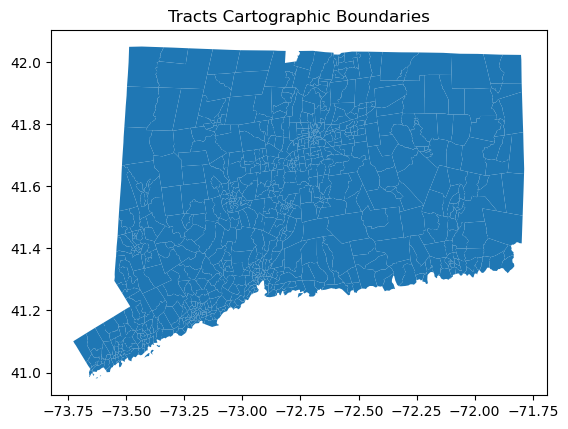

In [2]:
import pygris
from pygris import tracts
from matplotlib import pyplot as plt
import pandas as pd
import folium
import numpy as np
import geopandas as gp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import libpysal as lp
from scipy.stats import linregress
import rasterio
from rasterstats import zonal_stats


# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

# Import tracts population data
pop = pd.read_csv("population.csv")

# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

# Project tracts
tracts = tracts.to_crs("EPSG:3857")

# Calculate area in KM
tracts["Area"] = tracts.area/1000**2

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]



In [3]:
# #import raster
# raster_path = 'ct_2016_ccap_hires_landcover_20200915.tif'
# landcover = rasterio.open(raster_path)
# arr = landcover.read(1)
# affine = landcover.transform

# zone = tracts.to_crs(landcover.crs)

In [4]:
# df_new = zonal_stats(zone, arr, affine=affine, categorical = True)

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [5]:
# df_categorical = pd.DataFrame(df_new)

# df_categorical['max_type'] = df_categorical.idxmax(axis=1)
# combined_df = pd.concat([tracts, df_categorical], axis=1)
# combined_df['max_type'] = combined_df['max_type'].astype(str)

# # save zonal stat to combined_data.csv
# combined_df.to_csv('combined_data.csv', index=False)

In [382]:
data = pd.read_csv("combined_data.csv")
data[pd.isnull(data.iloc[:,68:-1])] = 0

X = data.iloc[:,68:-2]
y = data["PopDensity"]


In [383]:
gdf = gp.read_file('tl_2016_09_tract.shp')

In [384]:
data
# 'GEOID' to str
gdf['TRACTCE'] = gdf['TRACTCE'].astype(int)
data['TRACTCE'] = data['TRACTCE'].astype(int)

In [385]:
# merge csv with shapfile using TRACTCE
merged_gdf = gdf.merge(data, on='TRACTCE', how='left')


In [386]:
# make merged_gdf into geo dataframe
merged_gdf = gp.GeoDataFrame(merged_gdf)

# drop out all rows that have no population density
merged_gdf = merged_gdf.dropna(subset=['PopDensity'], axis=0)
merged_gdf = merged_gdf[merged_gdf['PopDensity'] != 0]
merged_gdf = merged_gdf[merged_gdf['TRACTCE'] != 194202]

# define the geometry_x column to be the geometry feature 
merged_gdf.set_geometry("geometry_x", inplace=True)

# calculate Queen's neighbor weights for each tracts
w = lp.weights.Queen.from_dataframe(merged_gdf)
w.transform = 'R'

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":


In [387]:
# compute spatial lag of population density
merged_gdf['spatial_lag'] = lp.weights.lag_spatial(w, merged_gdf['PopDensity'])

# calculate the mean pop density of each tract's neighbors
merged_gdf['avg_neighbor_density'] = merged_gdf.groupby('TRACTCE')['spatial_lag'].transform('mean')

# download merged_gdf to csv file
merged_gdf.to_csv('merged_gdf.csv', index=False)

Spatial autocorrelation evaluation

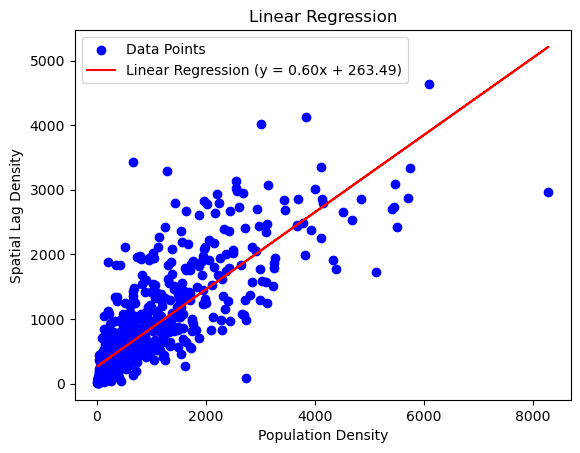

In [388]:
from sklearn.linear_model import LinearRegression

merged_csv_moran = pd.read_csv("merged_gdf.csv", usecols=['PopDensity', 'avg_neighbor_density', "Geo_NAME"]).dropna()

# Extract x and y columns from the DataFrame
x = merged_csv_moran['PopDensity'].values.reshape(-1, 1)  # Reshape to make it a 2D array for scikit-learn
y = merged_csv_moran['avg_neighbor_density'].values

# Create a scatter plot of x vs y
plt.scatter(x, y, color='blue', label='Data Points')

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Get the slope and intercept of the fitted line
slope = model.coef_[0]
intercept = model.intercept_

# Plot the fitted line
plt.plot(x, model.predict(x), color='red', label=f'Linear Regression (y = {slope:.2f}x + {intercept:.2f})')

# Add labels and title
plt.xlabel('Population Density')
plt.ylabel('Spatial Lag Density')
plt.title('Linear Regression')
plt.legend()

# Show plot
plt.show()


/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/3794579351.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'High-High' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_gdf.loc[(merged_gdf['avg_neighbor_density'] >= p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-High'


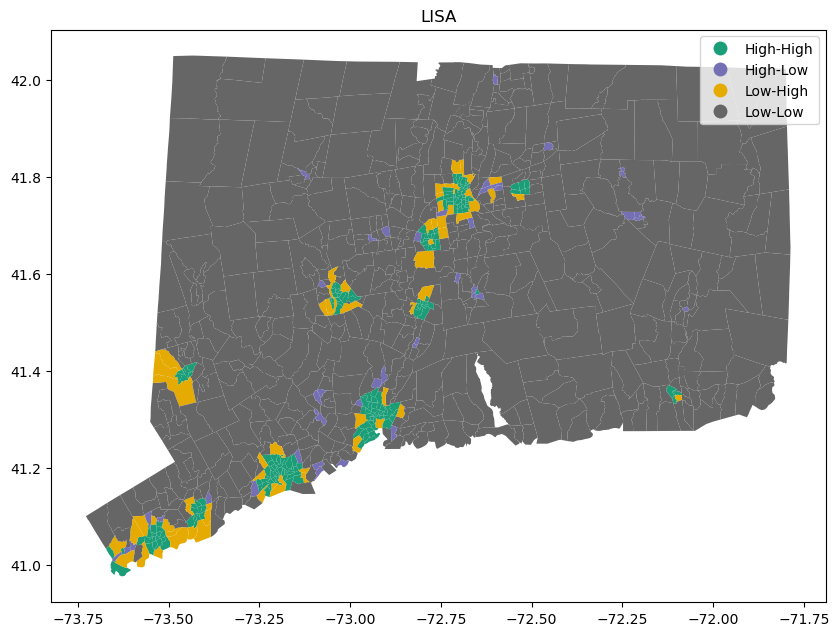

In [450]:
# Calculate the average for 'avg_neighbor_density' and 'PopDensity'
p = merged_gdf['avg_neighbor_density'].mean()
q = merged_gdf['PopDensity'].mean()

# Categorize the rows based on conditions
merged_gdf['category'] = 0  # Initialize category column
merged_gdf.loc[(merged_gdf['avg_neighbor_density'] >= p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-High'
merged_gdf.loc[(merged_gdf['avg_neighbor_density'] >= p) & (merged_gdf['PopDensity'] < q), 'category'] = 'Low-High'
merged_gdf.loc[(merged_gdf['avg_neighbor_density'] < p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-Low'
merged_gdf.loc[(merged_gdf['avg_neighbor_density'] < p) & (merged_gdf['PopDensity'] < q), 'category'] = 'Low-Low'

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='category', cmap='Dark2', legend=True, ax=ax)
plt.title('LISA')
plt.show()

In [397]:
merged_csv = pd.read_csv("merged_gdf.csv")

merged_gdf['County'] = merged_gdf['Geo_NAME'].str.split(',').str[1].str.strip().str.replace(' ', '')

merged_gdf = merged_gdf.dropna(subset=['County'])

merged_gdf['County'].unique()

array(['TollandCounty', 'HartfordCounty', 'NewHavenCounty',
       'FairfieldCounty', 'MiddlesexCounty', 'WindhamCounty',
       'LitchfieldCounty', 'NewLondonCounty'], dtype=object)

In [398]:
# X = merged_csv[['2', '5', '8', '11', '12', '13', '14', '15', '17', '18', '19', '20', '21', '7', '6', '0', '23', 'County']] # Features
# y = merged_csv[['PopDensity', 'County']]  # Target variable
!pip install spreg
import libpysal
from libpysal import weights
from spreg import ML_Lag


In [399]:
from libpysal.weights import Queen
from spreg import GM_Lag

In [432]:
# DONT RUN THIS BLOCK TWICE!!!

landcover_types = ['2', '5', '8', '11', '12', '13', '14', '15', '20', '21']
landcover_pct = ['2pct', '5pct', '8pct', '11pct', '12pct', '13pct', '14pct', '15pct', '20pct', '21pct']

merged_gdf['sum'] = merged_gdf[landcover_types].sum(axis=1)
#merged_gdf['sum'] = merged_gdf.apply(lambda row: row['2'] + row['5'], axis=1)
merged_gdf[landcover_pct] = merged_gdf[landcover_types].div(merged_gdf['sum'], axis=0).multiply(100).astype(float)

# download merged_gdf to csv file
merged_gdf.to_csv('merged_gdf_1111.csv', index=False)

In [433]:
merged_gdf[landcover_pct]

,2pct,5pct,8pct,11pct,12pct,13pct,14pct,15pct,20pct,21pct
0,5.709884,10.440186,2.514839,72.701933,0.343442,3.984609,0.071083,0.170707,0.432931,3.630385
1,50.002466,28.115856,0.351412,18.533429,0.645671,0.000000,0.000000,0.000000,0.861022,1.490144
2,7.181892,8.508337,2.780925,74.104358,0.464663,1.764194,0.015887,0.090866,0.223262,4.865618
3,8.480108,11.859112,4.075868,67.348372,1.090568,3.005348,0.319573,1.699937,0.764833,1.356280
4,13.085367,19.468680,5.257756,40.661121,0.220684,19.333355,0.055518,1.817865,0.099655,0.000000
...,...,...,...,...,...,...,...,...,...,...
836,27.305550,16.612163,0.882965,40.260155,1.397307,0.285682,0.003787,0.140533,1.587099,11.524759
837,3.990640,7.675258,6.005645,70.183478,1.490810,4.308320,0.550941,2.335574,0.508489,2.950845
838,11.706857,12.700768,2.230972,61.002012,1.703321,4.783566,0.143847,0.373377,0.633688,4.721591
839,12.706076,9.920015,1.285318,39.070517,4.739230,0.721248,0.077169,0.426813,2.777854,28.275758


In [434]:
predictors = landcover_pct + ['spatial_lag']
predictors

['2pct',
 '5pct',
 '8pct',
 '11pct',
 '12pct',
 '13pct',
 '14pct',
 '15pct',
 '20pct',
 '21pct',
 'spatial_lag']

In [444]:

# train_1 = merged_gdf[(merged_gdf['County'] != 'NewLondonCounty') & (merged_gdf['County'] != 'MiddlesexCounty')]
# test_1 = merged_gdf[(merged_gdf['County'] == 'NewLondonCounty') | (merged_gdf['County'] == 'MiddlesexCounty')]

y_train = np.array(merged_gdf['PopDensity']).reshape((-1,1))
x_train = np.array(merged_gdf[landcover_pct])

# y_test = np.array(test_1['PopDensity'])
# x_test = np.array(test_1[landcover_pct])

train_1_w = Queen.from_dataframe(merged_gdf)
# test_1_w = Queen.from_dataframe(test_1)

# Normalize the weights ! IMPORTANT
train_1_w.transform = 'R'


/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":


In [445]:
# queen spatial weight model
train_1_w.full()[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.2       ,
        0.2       ],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.        ,
        0.16666667],
       [0.        , 0.        , 0.        , ..., 0.2       , 0.2       ,
        0.        ]])

In [446]:
model = ML_Lag(y=y_train, x=x_train, w=train_1_w, name_y='PopDensity', name_x=landcover_pct, name_w='SpatialWeightsMatrix')
# the coefficients of the model
model.betas

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([[-512.        ],
       [  35.91244985],
       [  -0.89056232],
       [  -6.93433739],
       [  -6.93433739],
       [ -14.4090365 ],
       [   8.1751003 ],
       [  33.60602433],
       [ -14.93433739],
       [ -95.8248997 ],
       [  -0.89056232],
       [   0.75547188]])

In [447]:
# output for the model
model.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,-512.0,1775577811.532448,-0.0,1.0
1,2pct,35.91245,17755778.115324,0.000002,0.999998
2,5pct,-0.890562,17755778.115325,-0.0,1.0
3,8pct,-6.934337,17755778.115335,-0.0,1.0
4,11pct,-6.934337,17755778.115325,-0.0,1.0
5,12pct,-14.409037,17755778.115369,-0.000001,0.999999
6,13pct,8.1751,17755778.115329,0.0,1.0
7,14pct,33.606024,17755778.115567,0.000002,0.999998
8,15pct,-14.934337,17755778.115348,-0.000001,0.999999
9,20pct,-95.8249,17755778.115336,-0.000005,0.999996


In [430]:
# SEE OUTPUT FOR GM_Lag
# Build full table of regression coefficients
# pd.DataFrame(
#     {
#         # Pull out regression coefficients and
#         # flatten as they are returned as Nx1 array
#         "Coeff.": model.betas.flatten(),
#         # Pull out and flatten standard errors
#         "Std. Error": model.std_err.flatten(),
#         # Pull out P-values from t-stat object
#         "P-Value": [i[1] for i in model.z_stat],
#     },
#     # Round to four decimals
# ).round(4)

In [431]:
# estimate of spatial autoregressive coefficient
"{0:.6f}".format(model.rho) 

'0.855610'

In [427]:
# Pseudo R squared (squared correlation between y and ypred)
"{0:.6f}".format(model.pr2) 

'0.784932'

In [443]:
# AIC
"{0:.6f}".format(model.aic) 

'13399.967815'

In [428]:
# Sum of squared residuals
"{0:.4f}".format(model.utu)

'287750020.5426'

/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/3862628888.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.centroid.plot(ax=ax, c='black')


<Axes: >

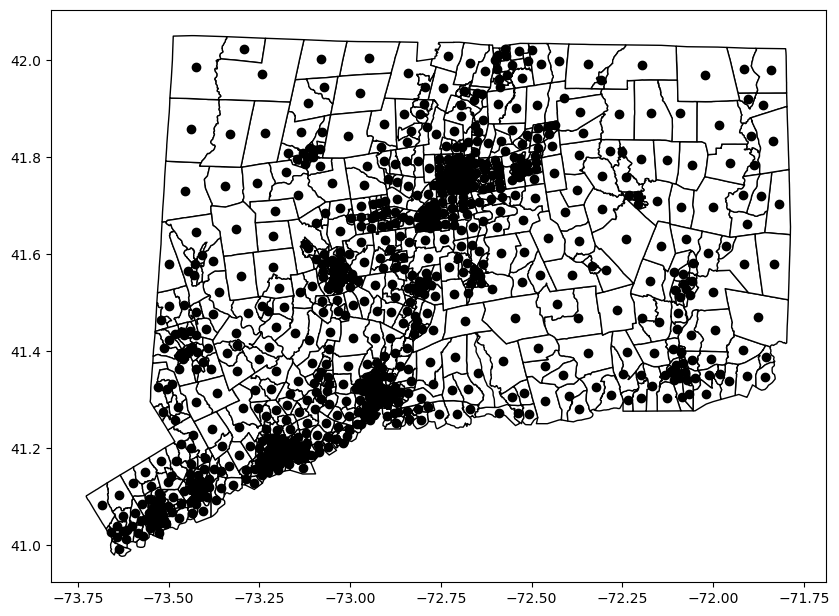

In [448]:
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
merged_gdf.centroid.plot(ax=ax, c='black')

In [452]:
centroids = merged_gdf.geometry.centroid

# Extract longitude and latitude
longitude = centroids.x
latitude = centroids.y

g_coords = list(zip(longitude,latitude))


/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/777703877.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = merged_gdf.geometry.centroid
